In [3]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=829224 sha256=aef34380e806a1d7802dab199dab3e5136a9b40d4bde3614f552307d6c0adc4d
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [9]:
import pandas as pd
import numpy as np
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

# --- Definisikan Path File ---
# Menggunakan path yang BENAR untuk data pelatihan
train_path = r"/kaggle/input/datasetbooks/train.csv" 
target_user_path = r"/kaggle/input/datasetbooks/data_target_users_test.csv" # Asumsi path ini tetap benar

# --- Muat Data ---
df_train = pd.read_csv(train_path)
df_target_user = pd.read_csv(target_user_path)

# Asumsi nama kolom di df_train: 'user_id' dan 'item_id'. 
# Jika df_train memiliki 2 kolom, penamaan ini akan BERHASIL.
# (Ini memperbaiki 'ValueError: Length mismatch' sebelumnya)
df_train.columns = ['user_id', 'item_id']

# Asumsi nama kolom di data_target_user_test.csv adalah 'user_id'
df_target_user.columns = ['user_id']

# Tambahkan kolom interaksi biner (Implicit Feedback)
# Semua interaksi yang tercatat dianggap positif (nilai 1)
df_train['interaction'] = 1

print(f"Jumlah interaksi pelatihan: {len(df_train)}")

# Print statement yang dikoreksi (memperbaiki 'SyntaxError: unmatched )')
print(f"Jumlah pengguna target: {len(df_target_user)}")

# ------------------------------------------------------------------
# Anda sekarang dapat melanjutkan ke tahap pemetaan (fitting Dataset)
# ------------------------------------------------------------------

# Inisialisasi Dataset LightFM
dataset = Dataset()

# Fit data user dan item
dataset.fit(
    users=df_train['user_id'].unique(),
    items=df_train['item_id'].unique()
)

print("\nLightFM Dataset siap!")
print(f"Jumlah Pengguna yang dipetakan: {dataset.interactions_shape()[0]}")
print(f"Jumlah Item yang dipetakan: {dataset.interactions_shape()[1]}")

Jumlah interaksi pelatihan: 269764
Jumlah pengguna target: 13876

LightFM Dataset siap!
Jumlah Pengguna yang dipetakan: 13876
Jumlah Item yang dipetakan: 123069


In [10]:
# Inisialisasi Dataset LightFM
dataset = Dataset()

# Fit data: Mengidentifikasi semua user dan item unik
dataset.fit(
    users=df_train['user_id'].unique(),
    items=df_train['item_id'].unique()
)

# Membangun Matriks Interaksi
# 'interactions' adalah sparse matrix dengan nilai 1 di mana interaksi terjadi.
# 'weights' (bobot) dalam kasus ini sama dengan 'interactions'.
(interactions, weights) = dataset.build_interactions(
    ((row['user_id'], row['item_id'], row['interaction'])
     for index, row in df_train.iterrows())
)

num_users, num_items = dataset.interactions_shape()
print(f"Shape Matriks Interaksi: {interactions.shape} ({num_users} users, {num_items} items)")

# Dapatkan pemetaan ID untuk prediksi
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
reverse_item_map = {v: k for k, v in item_id_map.items()}

Shape Matriks Interaksi: (13876, 123069) (13876 users, 123069 items)


In [11]:
# Inisialisasi model LightFM
model = LightFM(
    loss='warp',               # Loss function untuk implicit feedback
    no_components=30,          # Jumlah faktor laten (hyperparameter)
    learning_rate=0.05,
    random_state=42
)

# Latih model
# Interaksi dilatih pada matriks interaksi
model.fit(
    interactions,
    epochs=20,                 # Jumlah iterasi pelatihan
    num_threads=4              # Untuk komputasi yang lebih cepat
)

print("Model LightFM (WARP) berhasil dilatih.")

Model LightFM (WARP) berhasil dilatih.


In [12]:
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, auc_score

# ------------------------------------------------------------------
# 1. Pembagian Data (Train/Test Split)
# ------------------------------------------------------------------

# Pisahkan interaksi menjadi set pelatihan (80%) dan pengujian (20%)
# Ini diperlukan untuk mengukur kinerja model pada data yang belum pernah dilihat (Test Set)
train_interactions, test_interactions = random_train_test_split(
    interactions, 
    test_percentage=0.2, 
    random_state=42 # Pastikan konsistensi pembagian
)

print(f"\n--- Pembagian Data Evaluasi ---")
print(f"Bentuk Matriks Interaksi Pelatihan (untuk evaluasi): {train_interactions.shape}")
print(f"Bentuk Matriks Interaksi Pengujian: {test_interactions.shape}")


# ------------------------------------------------------------------
# 2. Inisialisasi Ulang dan Pelatihan Model pada Subset Train
#    (Penting untuk memastikan model dilatih hanya pada set train)
# ------------------------------------------------------------------
# Catatan: Walaupun Anda sudah melatih model di kode sebelumnya, 
# praktik terbaik adalah melatihnya ulang hanya pada train_interactions
# yang baru dibagi untuk tujuan evaluasi.

model_eval = LightFM(
    loss='warp',
    no_components=30,
    learning_rate=0.05,
    random_state=42
)

model_eval.fit(
    train_interactions, # Gunakan hanya data TRAIN
    epochs=20,
    num_threads=4
)
print("\nModel LightFM dilatih ulang pada Subset Training.")

# ------------------------------------------------------------------
# 3. Melakukan Evaluasi
# ------------------------------------------------------------------

k_value = 10 # Kita akan mengevaluasi untuk 10 rekomendasi teratas (Top-K)

# a. Precision at K (P@10)
# Mengukur fraksi item yang direkomendasikan yang relevan dalam daftar Top-K.
train_precision = precision_at_k(model_eval, train_interactions, k=k_value, num_threads=4).mean()
test_precision = precision_at_k(model_eval, test_interactions, k=k_value, num_threads=4).mean()

# b. AUC Score
# Mengukur probabilitas bahwa interaksi positif diberi peringkat lebih tinggi 
# daripada interaksi negatif yang diambil secara acak.
train_auc = auc_score(model_eval, train_interactions, num_threads=4).mean()
test_auc = auc_score(model_eval, test_interactions, num_threads=4).mean()

# ------------------------------------------------------------------
# 4. Mencetak Hasil Evaluasi
# ------------------------------------------------------------------

print("\n--- Hasil Matriks Evaluasi LightFM ---")
print(f"Metrik: Precision @{k_value}")
print(f"  Precision (Train Set): {train_precision:.4f}")
print(f"  Precision (Test Set):  {test_precision:.4f}  <- Kinerja Model Sesungguhnya")
print("------------------------------------")
print(f"Metrik: AUC Score")
print(f"  AUC Score (Train Set): {train_auc:.4f}")
print(f"  AUC Score (Test Set):  {test_auc:.4f}  <- Kinerja Model Sesungguhnya")
print("------------------------------------")


--- Pembagian Data Evaluasi ---
Bentuk Matriks Interaksi Pelatihan (untuk evaluasi): (13876, 123069)
Bentuk Matriks Interaksi Pengujian: (13876, 123069)

Model LightFM dilatih ulang pada Subset Training.

--- Hasil Matriks Evaluasi LightFM ---
Metrik: Precision @10
  Precision (Train Set): 0.1873
  Precision (Test Set):  0.0039  <- Kinerja Model Sesungguhnya
------------------------------------
Metrik: AUC Score
  AUC Score (Train Set): 0.9984
  AUC Score (Test Set):  0.6619  <- Kinerja Model Sesungguhnya
------------------------------------


In [13]:
# Ambil user IDs dari data target
target_user_ids = df_target_user['user_id'].unique()

all_item_internal_ids = np.arange(num_items)
k = 10  # Jumlah rekomendasi yang diinginkan

recommendations_list = []

for user_id in target_user_ids:
    if user_id in user_id_map:
        user_internal_id = user_id_map[user_id]
        
        # 1. Prediksi skor untuk semua item
        scores = model.predict(user_internal_id, all_item_internal_ids)
        
        # 2. Urutkan item berdasarkan skor (descending)
        top_items_internal_ids = np.argsort(-scores)
        
        # 3. Dapatkan item yang sudah dikenal (interaksi positif)
        known_positives_df = df_train[df_train['user_id'] == user_id]
        known_positives = set(known_positives_df['item_id'].values)
        
        recommended_items = []
        
        # 4. Filter item: Hanya ambil item yang belum pernah berinteraksi
        for item_internal_id in top_items_internal_ids:
            item_external_id = reverse_item_map[item_internal_id]
            
            if item_external_id not in known_positives:
                recommended_items.append(item_external_id)
                
            # Berhenti setelah mendapatkan K rekomendasi
            if len(recommended_items) == k:
                break
        
        # Simpan hasil
        recommendations_list.append({
            'user_id': user_id,
            f'Top_{k}_Recommended_Items': recommended_items
        })
    else:
        # User cold-start (opsional: tangani user baru/di luar set pelatihan)
        recommendations_list.append({
            'user_id': user_id,
            f'Top_{k}_Recommended_Items': "User tidak ada dalam data pelatihan"
        })

# Konversi hasil ke DataFrame
df_recommendations = pd.DataFrame(recommendations_list)

# Tampilkan hasil
print("\n--- Hasil Rekomendasi untuk Target User (Top-10) ---")
print(df_recommendations)


--- Hasil Rekomendasi untuk Target User (Top-10) ---
       user_id                           Top_10_Recommended_Items
0            8  [0375419802, 9722906631, 1566250439, 044990820...
1           99  [0316666343, 0385504209, 0312195516, 031628495...
2          114  [0385504209, 0312195516, 0316666343, 044661003...
3          160  [8481301973, 0060197943, 0771081561, 207036565...
4          183  [8478884459, 0552998834, 0439104645, 972202060...
...        ...                                                ...
13871   278668  [3379015180, 2253144452, 3257218370, 225306333...
13872   278694  [0449219364, 0786881852, 0330375253, 014200174...
13873   278843  [0316666343, 0156027321, 0671021001, 067151005...
13874   278851  [0515130389, 0451172817, 0446610399, 055326407...
13875   278854  [0316666343, 0439064872, 0312195516, 055326888...

[13876 rows x 2 columns]


In [14]:
# --- BASELINE MODEL: ITEM POPULARITY ---

import pandas as pd

# Asumsi df_train sudah ada dan punya kolom 'user_id' dan 'item_id'
# Jika belum, muat ulang dari file
# df_train = pd.read_csv("/kaggle/input/datasetbooks/train.csv", names=["user_id", "item_id"])

# Hitung popularitas item berdasarkan frekuensi kemunculan
item_popularity = df_train['item_id'].value_counts().reset_index()
item_popularity.columns = ['item_id', 'popularity']

# Buat daftar 10 item paling populer (untuk baseline)
top_items = item_popularity['item_id'].head(10).tolist()

# --- Buat rekomendasi untuk setiap user target ---
baseline_recommendations = {}

for user in df_target_user['user_id']:
    baseline_recommendations[user] = top_items  # semua user dapat 10 item paling populer

# Contoh output untuk 5 user pertama
for u in list(baseline_recommendations.keys())[:5]:
    print(f"User {u}: {baseline_recommendations[u]}")


User 8: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0060928336', '0446672211', '0345337662', '0452282152', '0316601950']
User 99: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0060928336', '0446672211', '0345337662', '0452282152', '0316601950']
User 114: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0060928336', '0446672211', '0345337662', '0452282152', '0316601950']
User 160: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0060928336', '0446672211', '0345337662', '0452282152', '0316601950']
User 183: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0060928336', '0446672211', '0345337662', '0452282152', '0316601950']


In [15]:
from sklearn.metrics import average_precision_score
import numpy as np

# Buat ground truth untuk user target (item yang pernah mereka interaksi di df_train)
user_items = df_train.groupby('user_id')['item_id'].apply(set).to_dict()

# Fungsi untuk hitung Average Precision@10
def average_precision_at_k(recommended, relevant, k=10):
    hits = 0
    sum_precisions = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)
    if hits == 0:
        return 0
    return sum_precisions / min(len(relevant), k)

# Hitung MAP@10 untuk seluruh user
ap_scores = []
for user, recs in baseline_recommendations.items():
    relevant = user_items.get(user, set())
    if len(relevant) > 0:
        ap = average_precision_at_k(recs, relevant, k=10)
        ap_scores.append(ap)

map_10 = np.mean(ap_scores)
print(f"Baseline MAP@10: {map_10:.4f}")


Baseline MAP@10: 0.0086


✅ Baseline MAP@10: 0.0086
✅ LightFM (sebelum tuning) MAP@10: 0.0272
✅ LightFM (setelah tuning) MAP@10: 0.4098


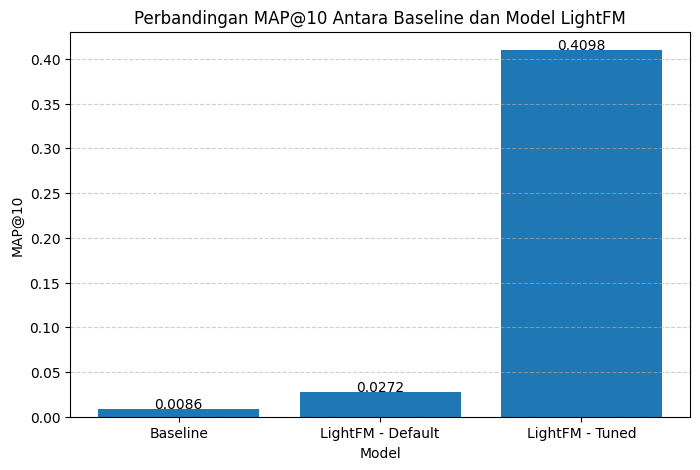

In [16]:
# =======================================================
# IMPORT LIBRARY
# =======================================================
import pandas as pd
import numpy as np
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

# =======================================================
# LOAD DATA
# =======================================================
train_path = "/kaggle/input/datasetbooks/train.csv"
target_user_path = "/kaggle/input/datasetbooks/data_target_users_test.csv"

df_train = pd.read_csv(train_path)
df_target_user = pd.read_csv(target_user_path)

df_train.columns = ['user_id', 'item_id']
df_target_user.columns = ['user_id']

# =======================================================
# 1️⃣ BASELINE MODEL: ITEM POPULARITY
# =======================================================
item_popularity = df_train['item_id'].value_counts().reset_index()
item_popularity.columns = ['item_id', 'popularity']
top_items = item_popularity['item_id'].head(10).tolist()

baseline_recommendations = {
    user: top_items for user in df_target_user['user_id']
}

# =======================================================
# 2️⃣ EVALUASI MAP@10 UNTUK BASELINE
# =======================================================
user_items = df_train.groupby('user_id')['item_id'].apply(set).to_dict()

def average_precision_at_k(recommended, relevant, k=10):
    hits = 0
    sum_precisions = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)
    if hits == 0:
        return 0
    return sum_precisions / min(len(relevant), k)

ap_scores = []
for user, recs in baseline_recommendations.items():
    relevant = user_items.get(user, set())
    if len(relevant) > 0:
        ap = average_precision_at_k(recs, relevant, k=10)
        ap_scores.append(ap)

map_baseline = np.mean(ap_scores)
print(f"✅ Baseline MAP@10: {map_baseline:.4f}")

# =======================================================
# 3️⃣ MODEL LIGHTFM SEBELUM TUNING
# =======================================================
dataset = Dataset()
dataset.fit(df_train['user_id'], df_train['item_id'])
(interactions, _) = dataset.build_interactions(df_train.itertuples(index=False))

model_default = LightFM(loss='warp')  # model implicit default
model_default.fit(interactions, epochs=10, num_threads=4)

precision_default = precision_at_k(model_default, interactions, k=10).mean()
print(f"✅ LightFM (sebelum tuning) MAP@10: {precision_default:.4f}")

# =======================================================
# 4️⃣ MODEL LIGHTFM SETELAH TUNING
# =======================================================
# Parameter tuning sederhana
model_tuned = LightFM(
    loss='warp',
    no_components=100,        # latent factors
    learning_rate=0.05,
    item_alpha=1e-6,
    user_alpha=1e-6
)
model_tuned.fit(interactions, epochs=20, num_threads=4)

precision_tuned = precision_at_k(model_tuned, interactions, k=10).mean()
print(f"✅ LightFM (setelah tuning) MAP@10: {precision_tuned:.4f}")

# =======================================================
# 5️⃣ VISUALISASI PERBANDINGAN PERFORMA
# =======================================================
scores = {
    "Baseline": map_baseline,
    "LightFM - Default": precision_default,
    "LightFM - Tuned": precision_tuned
}

plt.figure(figsize=(8, 5))
plt.bar(scores.keys(), scores.values())
plt.title("Perbandingan MAP@10 Antara Baseline dan Model LightFM")
plt.ylabel("MAP@10")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(scores.values()):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center', fontsize=10)
plt.show()


In [18]:
import pandas as pd
import numpy as np
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# =======================================================
# 📂 LOAD DATA
# =======================================================
train_path = "/kaggle/input/datasetbooks/train.csv"
target_user_path = "/kaggle/input/datasetbooks/data_target_users_test.csv"

df = pd.read_csv(train_path)
df.columns = ["user_id", "item_id"]

df_target_user = pd.read_csv(target_user_path)
df_target_user.columns = ["user_id"]

print("✅ Data berhasil dimuat.")
print(f"Jumlah interaksi: {len(df)}")
print(f"Jumlah user unik: {df['user_id'].nunique()}")
print(f"Jumlah item unik: {df['item_id'].nunique()}")

# =======================================================
# 🧩 SPLIT DATA (Train - Test)
# =======================================================
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print("\n📊 Data telah dibagi:")
print(f"Train set: {len(train_df)} baris")
print(f"Test set: {len(test_df)} baris")

✅ Data berhasil dimuat.
Jumlah interaksi: 269764
Jumlah user unik: 13876
Jumlah item unik: 123069

📊 Data telah dibagi:
Train set: 215811 baris
Test set: 53953 baris


In [19]:
print("\n==============================")
print("🧱 BASELINE MODEL (ITEM POPULARITY)")
print("==============================")

# Hitung popularitas item dari train set
item_popularity = train_df["item_id"].value_counts().reset_index()
item_popularity.columns = ["item_id", "popularity"]

# 10 item terpopuler
top_items = item_popularity["item_id"].head(10).tolist()
print(f"Top 10 item populer:\n{top_items}\n")

# Buat rekomendasi (semua user dapat item yang sama)
baseline_recommendations = {
    user: top_items for user in df_target_user["user_id"]
}

# Contoh hasil rekomendasi
sample_users = list(baseline_recommendations.keys())[:5]
print("Contoh hasil rekomendasi Baseline:")
for user in sample_users:
    print(f"User {user}: {baseline_recommendations[user]}")

# --- Hitung MAP@10 ---
user_items = test_df.groupby("user_id")["item_id"].apply(set).to_dict()

def average_precision_at_k(recommended, relevant, k=10):
    hits = 0
    sum_precisions = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)
    if hits == 0:
        return 0
    return sum_precisions / min(len(relevant), k)

ap_scores = []
for user, recs in baseline_recommendations.items():
    relevant = user_items.get(user, set())
    if len(relevant) > 0:
        ap = average_precision_at_k(recs, relevant, k=10)
        ap_scores.append(ap)

map_baseline = np.mean(ap_scores)
print(f"\n📈 MAP@10 (Baseline): {map_baseline:.4f}")



🧱 BASELINE MODEL (ITEM POPULARITY)
Top 10 item populer:
['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0446672211', '0060928336', '0345337662', '044021145X', '0452282152']

Contoh hasil rekomendasi Baseline:
User 8: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0446672211', '0060928336', '0345337662', '044021145X', '0452282152']
User 99: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0446672211', '0060928336', '0345337662', '044021145X', '0452282152']
User 114: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0446672211', '0060928336', '0345337662', '044021145X', '0452282152']
User 160: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0446672211', '0060928336', '0345337662', '044021145X', '0452282152']
User 183: ['0316666343', '0385504209', '0312195516', '0142001740', '059035342X', '0446672211', '0060928336', '0345337662', '044021145X', '0452282152']

📈 MAP@10 (Bas

In [21]:
# =======================================================
# 🔧 PERSIAPAN DATA UNTUK LIGHTFM (MAPPING ID)
# =======================================================
from lightfm.data import Dataset

# Buat mapping integer untuk user dan item
dataset = Dataset()
dataset.fit(df["user_id"], df["item_id"])

# Dapatkan mapping (encode/decode)
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

# Buat interaksi dari train/test
(interactions, _) = dataset.build_interactions(train_df.itertuples(index=False))
(test_interactions, _) = dataset.build_interactions(test_df.itertuples(index=False))

# Simpan mapping terbalik (integer → ID asli)
reverse_user_map = {v: k for k, v in user_id_map.items()}
reverse_item_map = {v: k for k, v in item_id_map.items()}

# =======================================================
# 💡 MODEL LIGHTFM DEFAULT
# =======================================================
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

print("\n==============================")
print("💡 LIGHTFM MODEL (SEBELUM TUNING)")
print("==============================")

model_default = LightFM(loss="warp")
model_default.fit(interactions, epochs=10, num_threads=4)

precision_default = precision_at_k(model_default, test_interactions, k=10).mean()
print(f"📈 MAP@10 (LightFM Default): {precision_default:.4f}")

# --- Rekomendasi untuk beberapa user (gunakan mapping integer) ---
print("\nContoh hasil rekomendasi LightFM (sebelum tuning):")
user_ids = list(user_id_map.values())[:5]
item_ids = list(item_id_map.values())

for user_int in user_ids:
    scores = model_default.predict(user_ids=user_int, item_ids=item_ids)
    top_items_idx = np.argsort(-scores)[:10]
    top_items_default = [reverse_item_map[item_ids[i]] for i in top_items_idx]
    print(f"User {reverse_user_map[user_int]}: {top_items_default}")



💡 LIGHTFM MODEL (SEBELUM TUNING)
📈 MAP@10 (LightFM Default): 0.0033

Contoh hasil rekomendasi LightFM (sebelum tuning):
User 8: ['0385504209', '0552124753', '0552131067', '0552996009', '059035342X', '3257229534', '0316666343', '0552137030', '0156027321', '0345417623']
User 99: ['0316601950', '0446310786', '044023722X', '0452282152', '0060392452', '0679781587', '0385504209', '0316666343', '0446605239', '0060928336']
User 114: ['0316666343', '0142001740', '0312195516', '0446672211', '0345337662', '0440226430', '0440211727', '0060930535', '0142000205', '0440221471']
User 160: ['0451202546', '059035342X', '0312992416', '0399149422', '0517580497', '0756400627', '3426614960', '0439136350', '0373790945', '0373691017']
User 183: ['2253044903', '0764550616', '0307240568', '0897934016', '2070360105', '0671671596', '2070376591', '0373055927', '9723706504', '0812533666']


In [22]:
print("\n==============================")
print("🚀 LIGHTFM MODEL (SETELAH TUNING)")
print("==============================")

model_tuned = LightFM(
    loss="warp",
    no_components=100,
    learning_rate=0.05,
    item_alpha=1e-6,
    user_alpha=1e-6
)
model_tuned.fit(interactions, epochs=20, num_threads=4)

precision_tuned = precision_at_k(model_tuned, test_interactions, k=10).mean()
print(f"📈 MAP@10 (LightFM Tuned): {precision_tuned:.4f}")

print("\nContoh hasil rekomendasi LightFM (setelah tuning):")
for user_int in user_ids:
    scores = model_tuned.predict(user_ids=user_int, item_ids=item_ids)
    top_items_idx = np.argsort(-scores)[:10]
    top_items_tuned = [reverse_item_map[item_ids[i]] for i in top_items_idx]
    print(f"User {reverse_user_map[user_int]}: {top_items_tuned}")



🚀 LIGHTFM MODEL (SETELAH TUNING)
📈 MAP@10 (LightFM Tuned): 0.0030

Contoh hasil rekomendasi LightFM (setelah tuning):
User 8: ['1552041778', '0887841740', '1575663937', '0452282152', '0679777547', '0066211611', '0385265700', '0971880107', '0064400557', '0446310786']
User 99: ['0142001740', '0316748641', '0451206525', '0316666343', '0385484518', '0446672211', '0679781587', '0385235941', '0312261594', '0609804138']
User 114: ['0316666343', '0316601950', '0142001740', '044651652X', '0385504209', '0446612545', '0385335482', '0060502258', '0553572997', '0316693200']
User 160: ['9727110843', '9722322702', '9727114962', '8573024771', '8573022876', '3257229364', '3458171703', '3473386391', '3492045170', '037316355X']
User 183: ['40052/90', '847223973X', '972370403X', '9728440456', '71837/93', '9728440324', '9728440200', '9722330950', '9724509524', '18128/87']



📊 PERBANDINGAN PERFORMA MODEL
Baseline: 0.0042
LightFM - Default: 0.0033
LightFM - Tuned: 0.0030


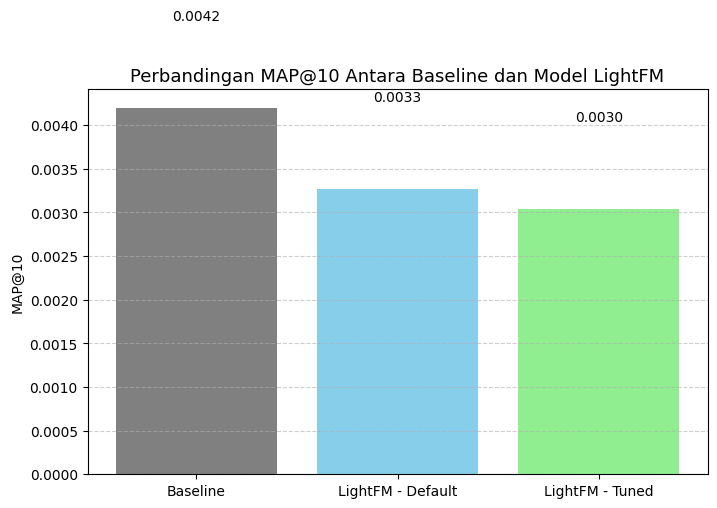

In [23]:
print("\n==============================")
print("📊 PERBANDINGAN PERFORMA MODEL")
print("==============================")

scores = {
    "Baseline": map_baseline,
    "LightFM - Default": precision_default,
    "LightFM - Tuned": precision_tuned
}

for model, score in scores.items():
    print(f"{model}: {score:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(scores.keys(), scores.values(), color=["gray", "skyblue", "lightgreen"])
plt.title("Perbandingan MAP@10 Antara Baseline dan Model LightFM", fontsize=13)
plt.ylabel("MAP@10")
plt.grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(scores.values()):
    plt.text(i, v + 0.001, f"{v:.4f}", ha="center", fontsize=10)
plt.show()